In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Import data and create df

data = pd.read_csv("/Users/Stacy/Documents/WebDevelopment/projects/sexualAssault_datasets/2010-2018_sexcrimes_violentcrimes.csv", index_col="CAD Event Number")
data = pd.DataFrame(data)

In [4]:
# Rename columns to be pythonic

data.columns = ['event_clearing', 'call_type', 'priority', 
                'initial_call_type', 'final_call_type', 'original_time_queued',
               'arrived_time', 'precinct', 'sector', 'beat']

In [5]:
# ID all calls cancelled by dispatch
cancelled_calls = data[data.event_clearing.str.contains("CANCELLED")]

# Delete rows with cxl'd calls

data = data[data.event_clearing != 'RESPONDING UNIT(S) CANCELLED BY RADIO']
data = data[data.event_clearing != 'DUPLICATED OR CANCELLED BY RADIO']

#### Clean time values

In [6]:
# Change original_time_queued to datetime
data['original_time_queued'] = pd.to_datetime(data.original_time_queued)

# Change arrived_time to datetime
data['arrived_time'] = pd.to_datetime(data.arrived_time, format='%b %d %Y %I:%M:%S:%f%p')

# Add time delta between original_time_queued and arrived_time
data['time_delta'] = ((data.arrived_time - data.original_time_queued)/np.timedelta64(1, 's')).astype(int)

In [7]:
# Add columns for arrived year and month

data['year'] = data.arrived_time.dt.year
data['month'] = data.arrived_time.dt.month

# For rows with bad arrived time: change month and year to original_time_queued
# Where arrive_time year = 1900, change data.year and data.month to original_time_queued year

mask = data.year < 1901
column_name_year = 'year'
column_name_month = 'month'
data.loc[mask, column_name_year] = data.original_time_queued.dt.year
data.loc[mask, column_name_month] = data.original_time_queued.dt.month

#### Define terms

In [8]:
# Define TRU initial call types
TRU_call_types = [
    'TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS)',
    'TRU - RAPE',
    'TRU - LEWD CONDUCT',
    'TRU - CHILD ABUSED, NEGLECTED',
    'TRU - THREATS',
    'TRU - ROBBERY',
    'TRU - ASLT - MOLESTED ADULT (GROPED, FONDLED, ETC)',
    'TRU - HARASSMENT',
    'TRU - SEX IN PUBLIC',
    'TRU - THEFT',
    'TRU - FOLLOW UP',
    'TRU - MVC - HIT AND RUN',
    'TRU - LURING',
    'TRU - FORGERY/CHKS/BUNCO/SCAMS/ID THEFT',
    'TRU - SUSPICIOUS CIRCUMSTANCES']

In [9]:
# Define terms that ID which crime_type

# Define terms that ID rape CFS
rape_terms = 'STRANGER|ACQUAINTANCE'
rape_call_types = [
    '--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    '--RAPE - UNKNOWN SUSPECT (STRANGER)']

# Define terms that ID sex crimes
sex_crime_terms = 'CSEC|LEWD|MOLESTING|STRANGER|ACQUAINTANCE'
sex_crime_call_types = [
    '--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT',
    '--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    '--RAPE - UNKNOWN SUSPECT (STRANGER)',
    '--SEX OFFENSES (RAPE) - MOLESTING',
    '--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)']

# Define terms that ID other violent crimes
violent_crime_terms = 'KIDNAP|HOMICIDE|SHOOTING|ASSAULTS|ROBBERY'
violent_crime_call_types = [
    '--ASSAULTS - FIREARM INVOLVED',
    '--ROBBERY - ARMED',
    '--HOMICIDE',
    '--KIDNAP - GENERAL',
    '--DRIVE BY SHOOTING - NO INJURIES']

In [10]:
# ID clearing codes for is_arrest

arrest_cc = ['PHYSICAL ARREST MADE']

### Add columns for is_arrest, is_TRU, and crime_type

In [47]:
# Add column identifying if there was an arrest
data['is_arrest'] = np.where(data['event_clearing'].isin(arrest_cc), 'yes', 'no')

# Add column identifying if this was A TRU call
data['is_TRU'] = np.where(data['initial_call_type'].isin(TRU_call_types), 'yes', 'no')

# Add column identifying crime type
data['crime_type'] = np.where(data['final_call_type'].isin(sex_crime_call_types), 'sex crime', 'violent crime')

### 1. 2018 Sees increase in reports of sex crimes
In the same time period, Seattle saw a decrease in the reporting of other violent crimes.

In [25]:
# Delete I think

# Create df that labels each call type as a violent crime, sex crime, or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)


temp_df = data[is_rape | is_vc | is_sex_crime]
#temp_df['crime_type'] = np.where(temp_df['final_call_type'].isin(sex_crime_call_types), 'sex crime', 'violent crime')
temp_df['crime_type'] = np.where(temp_df['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(temp_df['final_call_type'].isin(sex_crime_call_types), 'non-rape sex crime', 'violent crime')))

In [52]:
# Add crime_type for each call type as a violent crime, sex crime, or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)
is_lewd_conduct = data['final_call_type'].str.contains("LEWD")
is_arrest_mask = data['is_arrest'] == "yes"

data['crime_type'] = np.where(data['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(data['final_call_type'].isin(sex_crime_call_types),
                                          'non-rape sex crime', 'violent crime')))


2017 saw an increase in calls reporting sex crimes, whereas other violent crimes in the city continued a downward trend tht began in 2015.

Reports of non-rape sex crime increased each year of this analysis except for 2012. Between 2010 and 2018 the number of calls reporting non-rape sex crimes has nearly doubled in Seattle.

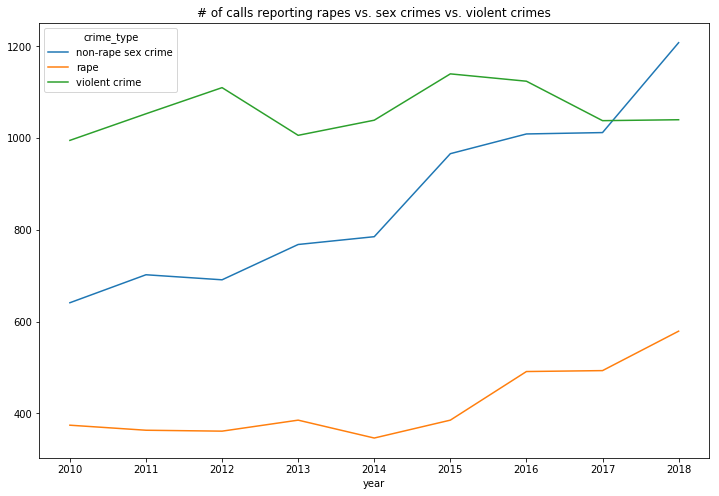

In [36]:
# Compare number of rape calls, non-rape sex crime calls, and violent crime calls by year

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(12,8),
    title="# of calls reporting rapes vs. sex crimes vs. violent crimes")

Between 2010 and 2018 there has been a general increase in the number of calls each year for lewd conduct. During this time period, the North, East and West precincts lewd conduct calls have steadily increased, while these calls in the South and Southwest precincts have remained mostly flat. 

In 2015 and 2018 there were marked increases in these calls in the North, East and West precincts.

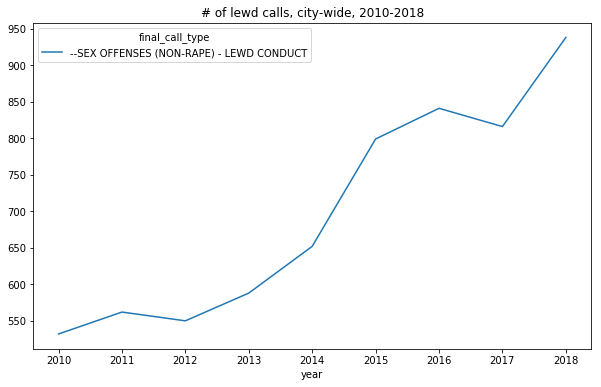

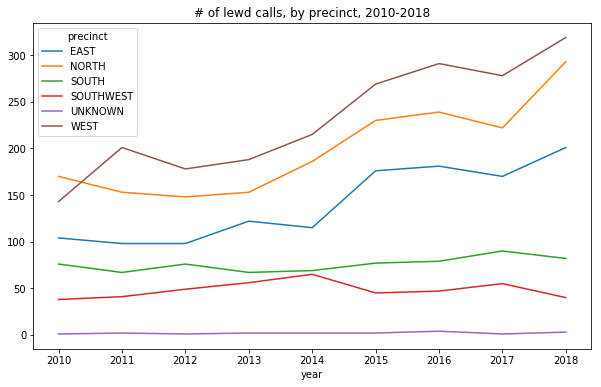

In [39]:
# Plot lewd conduct calls, by precinct, over the years
lewd_df = data[is_lewd_conduct]

lewd_df.groupby('final_call_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of lewd calls, city-wide, 2010-2018")

lewd_df.groupby('precinct').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of lewd calls, by precinct, 2010-2018")


In [48]:
data.head()

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,time_delta,year,month,crime_type,is_arrest,is_TRU
CAD Event Number,,,,,,,,,,,,,,,,
2010000066820,ASSISTANCE RENDERED,911,2,MENTAL - PERSON OR PICKUP/TRANSPORT,--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT,2010-02-27 22:54:25,2010-02-27 22:55:45,NORTH,UNION,U1,80,2010,2,sex crime,no,no
2010000000327,PHYSICAL ARREST MADE,911,1,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),--ASSAULTS - FIREARM INVOLVED,2010-01-01 03:13:06,2010-01-01 03:14:51,SOUTH,ROBERT,R3,105,2010,1,violent crime,yes,no
2010000000451,REPORT WRITTEN (NO ARREST),911,2,THEFT OF SERVICES,--ROBBERY - ARMED,2010-01-01 05:46:54,2010-01-01 06:39:35,NORTH,UNION,U1,3161,2010,1,violent crime,no,no
2010000000466,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",3,RAPE,--RAPE - KNOWN SUSPECT (ACQUAINTANCE),2010-01-01 06:28:49,2010-01-01 06:40:09,EAST,GEORGE,G1,680,2010,1,sex crime,no,no
2010000000776,REPORT WRITTEN (NO ARREST),911,3,RAPE,--RAPE - KNOWN SUSPECT (ACQUAINTANCE),2010-01-01 15:05:57,2010-01-01 15:12:26,SOUTHWEST,FRANK,F3,389,2010,1,sex crime,no,no


## 2. Arrests for VC have increased

Not sure about this - doesn't appear to be strong information

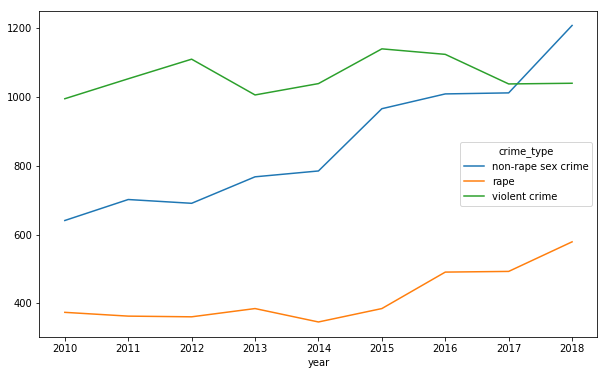

In [110]:

arrest_df = data['is_arrest'] == "yes"


data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6))


In [133]:
# Calculate arrest percentages by crime type for each year
arrest_percent_by_yr = pd.crosstab([data.crime_type, data.year],data.is_arrest,
                         normalize = 'index')

# Multiply all percentages by 100 for graphing. 
arrest_percent_by_yr *= 100

arrest_percent_by_yr.head()

is_arrest                       no       yes
crime_type         year                     
non-rape sex crime 2010  92.667707  7.332293
                   2011  93.589744  6.410256
                   2012  92.619392  7.380608
                   2013  92.447917  7.552083
                   2014  93.885350  6.114650

In [134]:
arrest_percent_by_yr.reset_index(inplace=True)

arrest_percent_by_yr.head()

is_arrest,crime_type,year,no,yes
0,non-rape sex crime,2010,92.667707,7.332293
1,non-rape sex crime,2011,93.589744,6.410256
2,non-rape sex crime,2012,92.619392,7.380608
3,non-rape sex crime,2013,92.447917,7.552083
4,non-rape sex crime,2014,93.885350,6.114650


In [135]:
arrest_percent_by_yr = arrest_percent_by_yr.drop('no', axis=1)
arrest_percent_by_yr.head()

is_arrest,crime_type,year,yes
0,non-rape sex crime,2010,7.332293
1,non-rape sex crime,2011,6.410256
2,non-rape sex crime,2012,7.380608
3,non-rape sex crime,2013,7.552083
4,non-rape sex crime,2014,6.114650


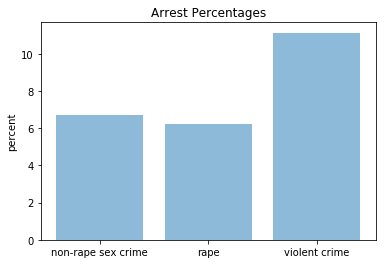

In [56]:
# Plot only arrests as bar graph. 
plt.bar(arrest_percent.index, arrest_percent.yes, align='center', alpha=0.5)
plt.ylabel('percent')
plt.title('Arrest Percentages')

plt.show()